# Test for QAOA Hamiltonian Mapper for MAX-CUT Graphs
## Undirected Graphs Using Networkx

In [1]:
%matplotlib inline

# import math tools
import numpy as np

# import networkx
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

/home/anand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


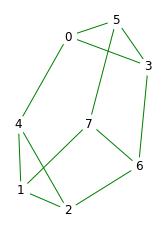

In [2]:
#Generate a graph here using networkx
# Number of Nodes
n = 8
degree = 3

# Create the graph
G = nx.random_regular_graph(degree, n)

plt.subplot(121)

nx.draw(G,with_labels=1, pos=nx.spring_layout(G), node_color='w', edge_color='g')

## Basic Mapping of the Hamiltonian for a graph with p=1

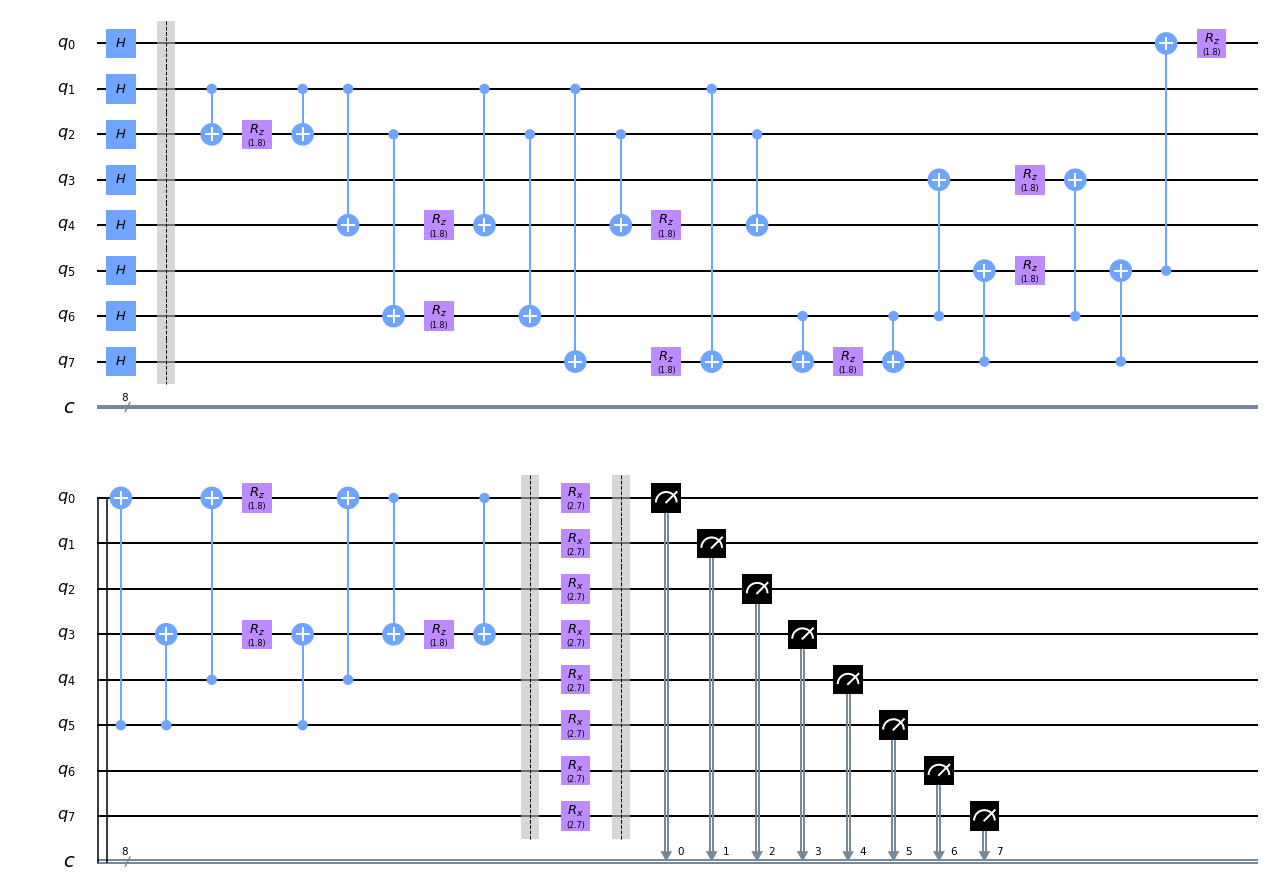

In [3]:
# Instansiate the Quantum circuit
hamiltonian = QuantumCircuit(len(G.nodes), len(G.nodes))

# Number of vertices added the Quantum Circuit as Hadamard gates
hamiltonian.h(range(len(G.nodes)))
hamiltonian.barrier()

gamma = 1.8
beta = 2.7

# Use the edge list to generate Cost-Hamiltonian
for e in G.edges:
    hamiltonian.cx(e[0],e[1])
    hamiltonian.rz(gamma, e[1])
    hamiltonian.cx(e[0],e[1])
    
hamiltonian.barrier()

# Generate the Mixer Hamiltonian 
hamiltonian.rx(beta,range(len(G.nodes)))

hamiltonian.barrier()
hamiltonian.measure(range(len(G.nodes)),range(len(G.nodes)))
hamiltonian.draw(output='mpl')


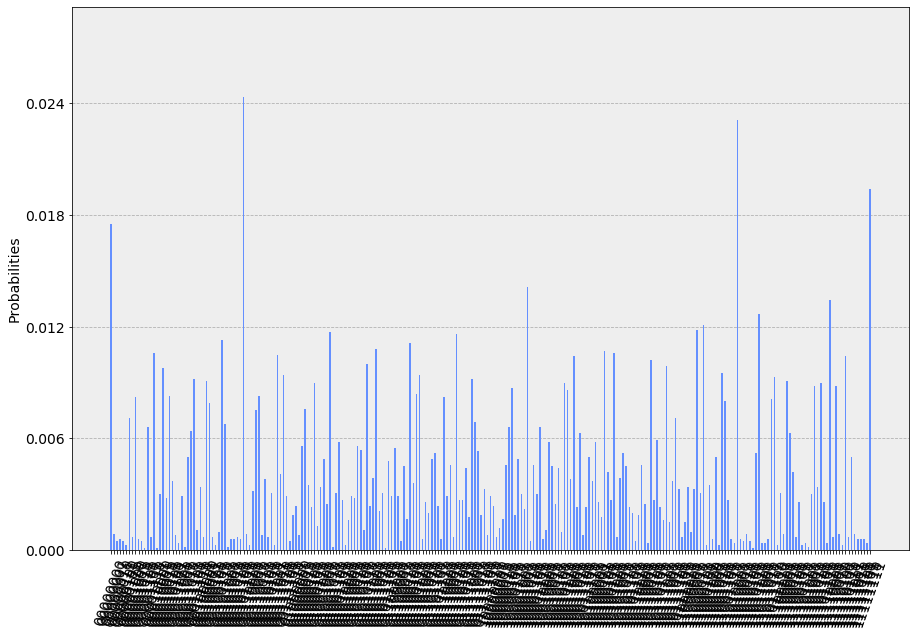

In [4]:
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(hamiltonian, backend=backend, shots=shots)
Hamil_results = simulate.result()

plot_histogram(Hamil_results.get_counts(),figsize = (15,10),bar_labels = False)

## Here need the process of calculating the Expectation value of the result

In [5]:
counts = Hamil_results.get_counts()

expecation_value = 0
#To calculate the expecation value of the Results
# to maintain consistency we let '0' be -1 and '1' be 1 for the partitioning
for c in counts:
    # Classical Algorithm for the MAX-CUT problem
    x = 0

    for e in G.edges:

            if c[e[0]] == "0":
                sig1 = -1
            else :
                sig1 = 1
                
            if c[e[1]] == "0":
                sig2 = -1
            else:
                sig2 = 1
                
            x += 0.5 * (1 - (sig1 * sig2))
    
    expecation_value += (counts[c] / shots) * x
    
    
# Show the expectation value of the Simulator
print(expecation_value)

6.044699999999999


## Create a function to edit the circuits' gamma,beta params

In [6]:
def modify_params(hamiltonian,gamma, beta):
    # Instansiate the Quantum circuit
    hamiltonian = QuantumCircuit(len(G.nodes), len(G.nodes))

    # Number of vertices added the Quantum Circuit as Hadamard gates
    hamiltonian.h(range(len(G.nodes)))
    hamiltonian.barrier()

    # Use the edge list to generate Cost-Hamiltonian
    for e in G.edges:
        hamiltonian.cx(e[0],e[1])
        hamiltonian.rz(gamma, e[1])
        hamiltonian.cx(e[0],e[1])
    
    hamiltonian.barrier()

    # Generate the Mixer Hamiltonian 
    hamiltonian.rx(beta,range(len(G.nodes)))

    hamiltonian.barrier()
    hamiltonian.measure(range(len(G.nodes)),range(len(G.nodes)))
                                                  
    return hamiltonian

## Create a function to calculate the Expectation value

In [7]:
def expecation_value(Hamil_results):
    counts = Hamil_results.get_counts()

    expecation_value = 0
    #To calculate the expecation value of the Results
    # to maintain consistency we let '0' be -1 and '1' be 1 for the partitioning
    for c in counts:
        # Classical Algorithm for the MAX-CUT problem
        x = 0

        for e in G.edges:

                if c[e[0]] == "0":
                    sig1 = -1
                else :
                    sig1 = 1

                if c[e[1]] == "0":
                    sig2 = -1
                else:
                    sig2 = 1

                x += 0.5 * (1 - (sig1 * sig2))

        expecation_value += (counts[c] / shots) * x
    return expecation_value

In [8]:
from scipy import optimize as opt
from scipy.optimize import Bounds

bounds = [[0, 2*np.pi], [0, np.pi]]
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
    
def QAOA(hyperparams):
    # Instansiate the Quantum circuit
    hamiltonian = QuantumCircuit(len(G.nodes), len(G.nodes))

    # Number of vertices added the Quantum Circuit as Hadamard gates
    hamiltonian.h(range(len(G.nodes)))
    hamiltonian.barrier()

    # Use the edge list to generate Cost-Hamiltonian
    for e in G.edges:
        hamiltonian.cx(e[0],e[1])
        hamiltonian.rz(hyperparams[0], e[1])
        hamiltonian.cx(e[0],e[1])
    
    hamiltonian.barrier()

    # Generate the Mixer Hamiltonian 
    hamiltonian.rx(hyperparams[1],range(len(G.nodes)))

    hamiltonian.barrier()
    hamiltonian.measure(range(len(G.nodes)),range(len(G.nodes)))
    
    backend      = Aer.get_backend("qasm_simulator")
    shots        = 10000

    simulate     = execute(hamiltonian, backend=backend, shots=shots)
    Hamil_results = simulate.result()
    
    r = -1.0 * expecation_value(Hamil_results);
    
    return r

In [9]:
hyperparams = [2.40514262, 0.71998964]
res = opt.minimize(QAOA, hyperparams,constraints=cons, tol= 1e-3, method='COBYLA')

In [10]:
print(res)
hyperparams = res.x

     fun: -6.381099999999999
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([3.7728891 , 0.42222138])


In [11]:
p_h = modify_params(hamiltonian, hyperparams[0], hyperparams[1])

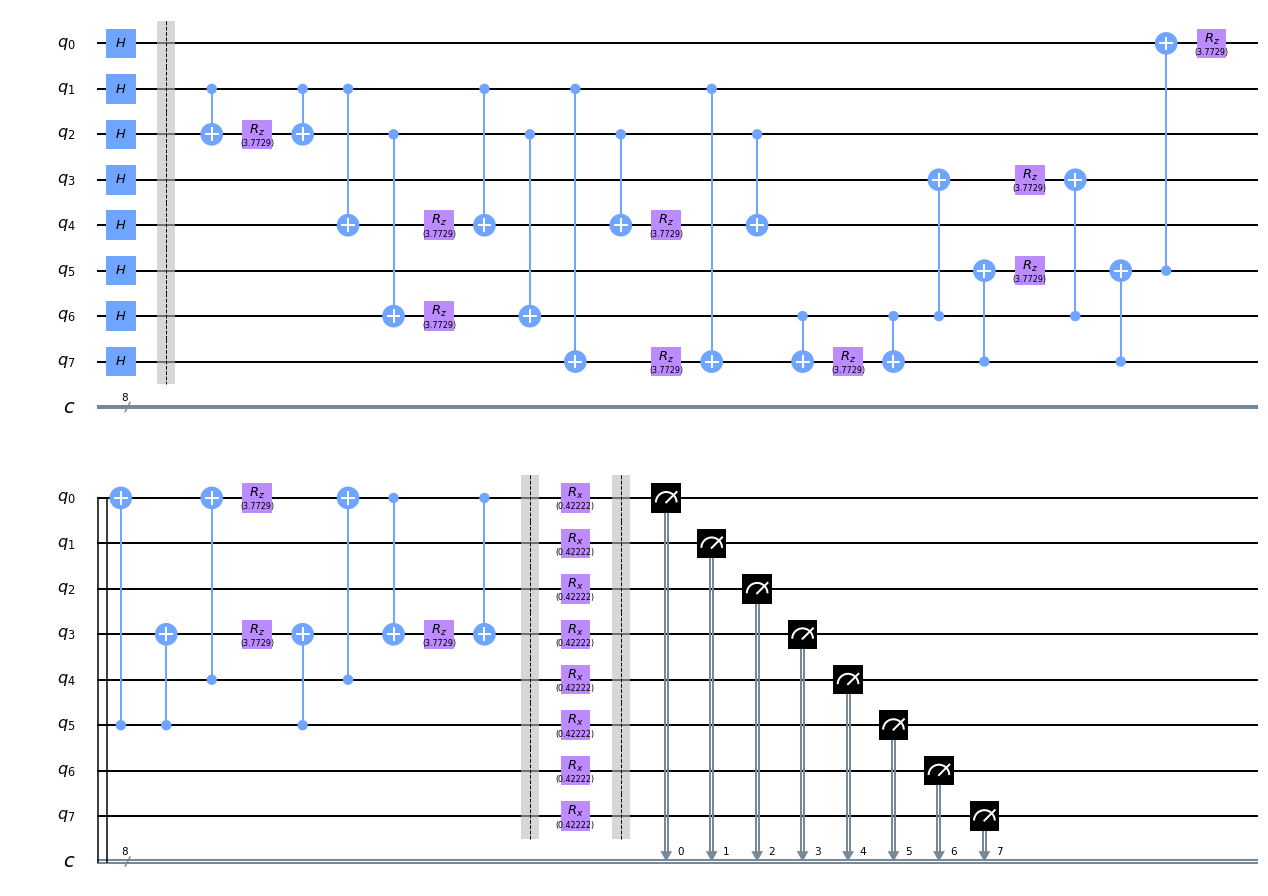

In [12]:
p_h.draw(output='mpl')

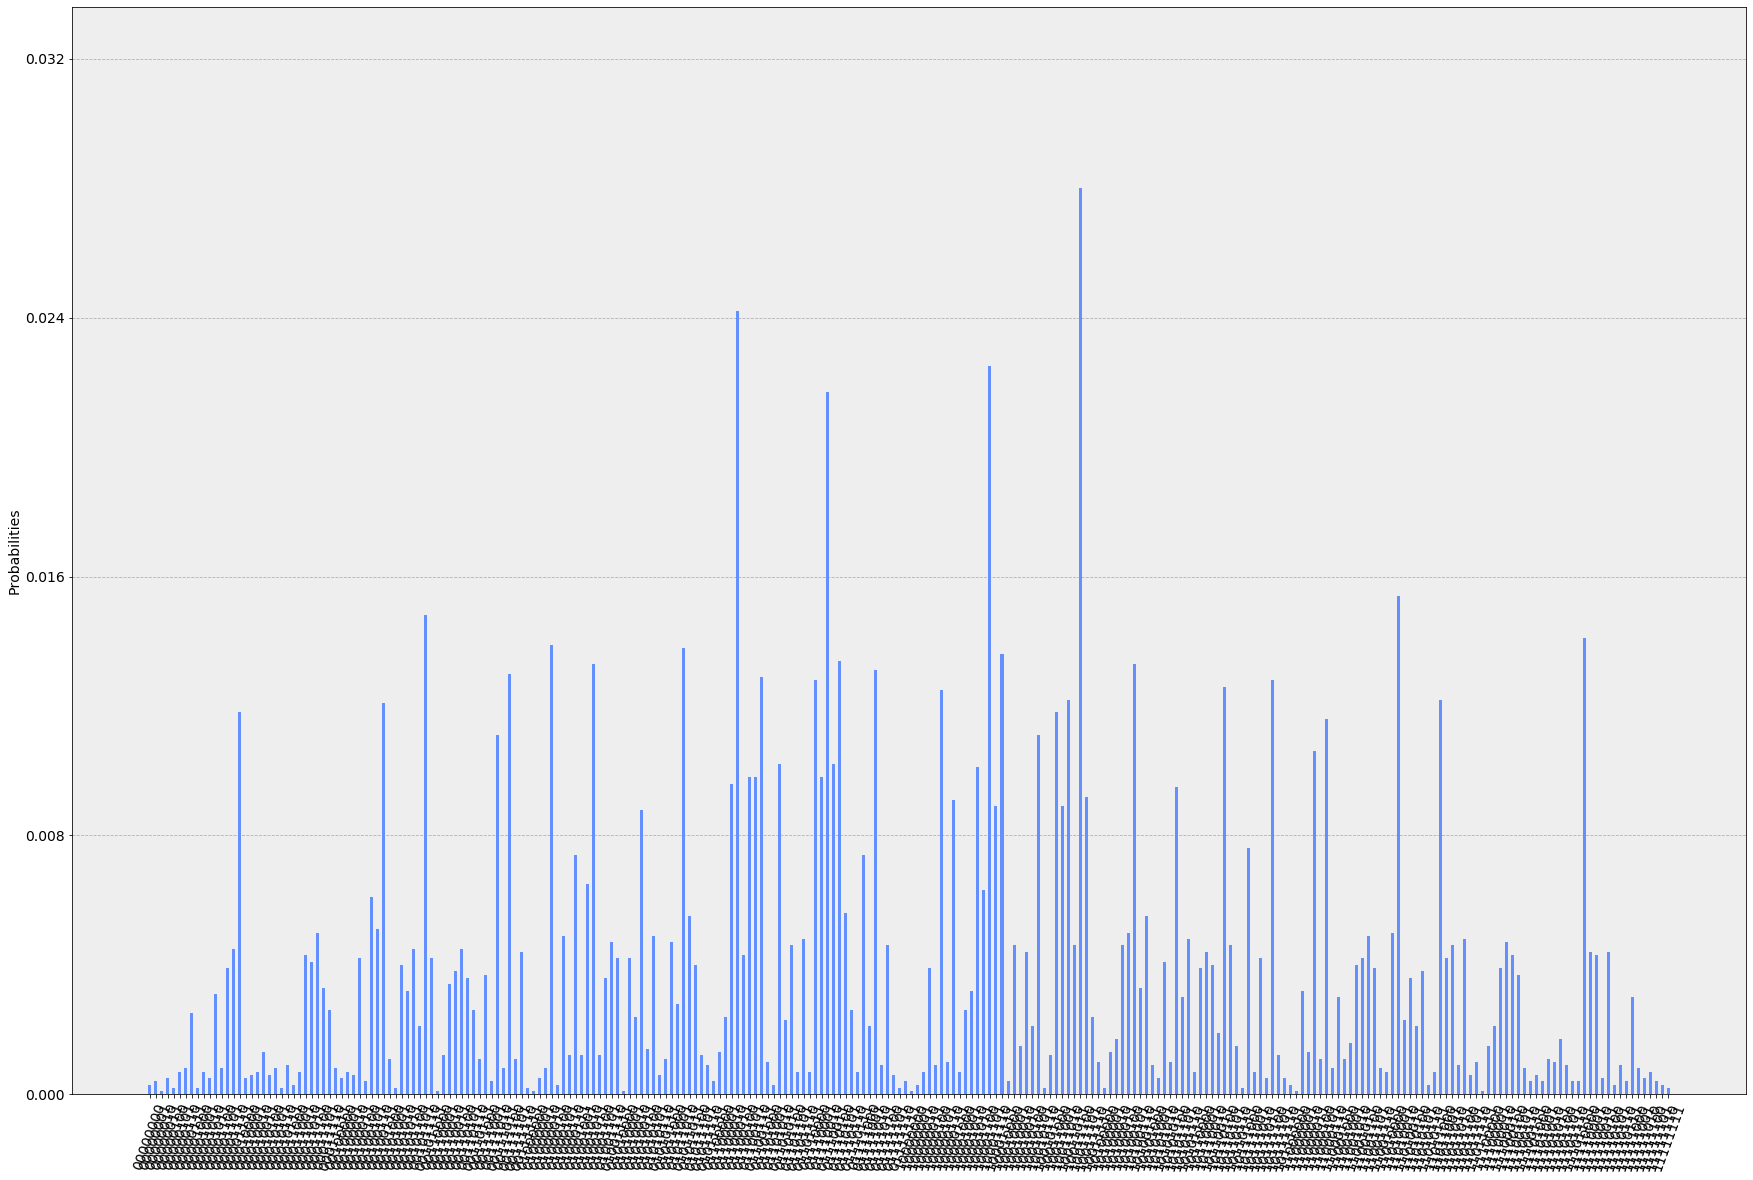

In [13]:
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(p_h, backend=backend, shots=shots)
Hamil_results = simulate.result()

plot_histogram(Hamil_results.get_counts(),figsize = (30,20),bar_labels = False)

In [14]:
print(Hamil_results.get_counts())

{'00001101': 39, '00000001': 4, '10100101': 133, '00001110': 45, '00011100': 50, '00000100': 2, '01100110': 98, '10111100': 128, '01000101': 49, '10101010': 41, '11011100': 48, '00110100': 45, '01111101': 6, '01000100': 3, '11011011': 9, '00000111': 25, '01110101': 56, '11100110': 8, '00100110': 51, '00111111': 2, '00101000': 11, '11100111': 4, '01010001': 42, '01101010': 102, '11001100': 49, '01001111': 42, '00001011': 31, '11101101': 9, '10001000': 7, '10100100': 50, '10111000': 76, '11000111': 30, '10101110': 48, '10001001': 26, '00000110': 8, '01010101': 49, '11110100': 44, '01100001': 24, '10110000': 39, '00010101': 8, '10110111': 2, '10100110': 33, '10010000': 4, '11100101': 37, '00100010': 6, '00101011': 32, '00101001': 2, '00000011': 5, '10011101': 92, '00001010': 5, '01011011': 55, '01011000': 47, '11001010': 40, '00111000': 37, '01010011': 88, '01111000': 74, '11001001': 16, '11011101': 6, '01011010': 138, '10011111': 10, '01010010': 24, '00011111': 8, '11010010': 23, '100001